In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 120)

In [3]:
df = pd.read_csv('/Users/sv.xxt/Downloads/Hospital_Inpatient_Discharges_(SPARCS_De-Identified)__2024_20251016.csv')

/var/folders/lf/wmkwxwwx63g16wbm61mzyxrm0000gn/T/ipykernel_61353/214457139.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/sv.xxt/Downloads/Hospital_Inpatient_Discharges_(SPARCS_De-Identified)__2024_20251016.csv')


In [4]:
df.head()

,Health Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
0,Hudson Valley,Westchester,5957001.0,1139.0,WESTCHESTER MEDICAL CENTER,0-17,OOS,F,White,Not Span/Hispanic,...,Moderate,Minor,Medical,Private Health Insurance,NaN,NaN,NaN,Y,46814.00,6772.07
1,New York City,Queens,7003001.0,1628.0,FLUSHING HOSPITAL MEDICAL CENTER,0-17,113,M,White,Spanish/Hispanic,...,Moderate,Moderate,Medical,Medicaid,NaN,NaN,NaN,Y,13490.00,15464.30
2,New York City,New York,7002054.0,1458.0,NEW YORK-PRESBYTERIAN HOSPITAL - NEW YORK WEIL...,70 or Older,100,M,White,Not Span/Hispanic,...,Moderate,Moderate,Medical,Medicare,Private Health Insurance,NaN,NaN,Y,49503.16,9324.77
3,New York City,New York,7002054.0,1464.0,NEW YORK-PRESBYTERIAN HOSPITAL - COLUMBIA PRES...,0-17,100,F,Other Race,Not Span/Hispanic,...,Minor,Minor,Medical,Private Health Insurance,NaN,NaN,2700,Y,27827.66,7304.27
4,New York City,New York,7002032.0,1466.0,MOUNT SINAI WEST,18-29,100,F,Other Race,Spanish/Hispanic,...,Moderate,Minor,Medical,Medicare,NaN,NaN,NaN,Y,32798.29,7948.10


In [5]:
df.describe()

,Operating Certificate Number,Permanent Facility Id,Discharge Year,APR DRG Code,APR MDC Code,APR Severity of Illness Code,Total Charges,Total Costs
count,2.191442e+06,2.191442e+06,2196737.0,2.196737e+06,2.196737e+06,2.196737e+06,2.196737e+06,2.196737e+06
mean,5.087132e+06,1.279496e+03,2024.0,4.143324e+02,1.030294e+01,2.145497e+00,9.062543e+04,2.641658e+04
std,2.245914e+06,1.869344e+03,0.0,2.440963e+02,5.985493e+00,9.252315e-01,1.894022e+05,5.537229e+04
min,1.010000e+05,1.000000e+00,2024.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.953000e+06,5.410000e+02,2024.0,1.940000e+02,5.000000e+00,1.000000e+00,2.357638e+04,7.415880e+03
50%,5.957001e+06,1.117000e+03,2024.0,3.830000e+02,9.000000e+00,2.000000e+00,4.724379e+04,1.411045e+04
75%,7.002032e+06,1.456000e+03,2024.0,6.400000e+02,1.500000e+01,3.000000e+00,9.451516e+04,2.778834e+04
max,7.004010e+06,1.562000e+04,2024.0,9.560000e+02,2.500000e+01,4.000000e+00,1.969486e+07,6.701232e+06


In [6]:
missing_counts = df.isna().sum()
missing_pct = df.isna().mean() * 100
pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
}).sort_values("missing_count", ascending=False)

,missing_count,missing_pct
Birth Weight,1988915,90.539514
Payment Typology 3,1956699,89.072975
Payment Typology 2,1204408,54.827137
CCSR Procedure Code,643764,29.305465
CCSR Procedure Description,643764,29.305465
Zip Code,41972,1.910652
Hospital County,5295,0.241039
Health Service Area,5295,0.241039
Operating Certificate Number,5295,0.241039
Permanent Facility Id,5295,0.241039


In [7]:
df.drop(columns=['Birth Weight','Payment Typology 3','Payment Typology 2','CCSR Procedure Description','Zip Code'], inplace=True)

In [8]:
before = len(df)
df = df.dropna().reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows with NaNs — {after} rows remain.")

Dropped 648162 rows with NaNs — 1548575 rows remain.


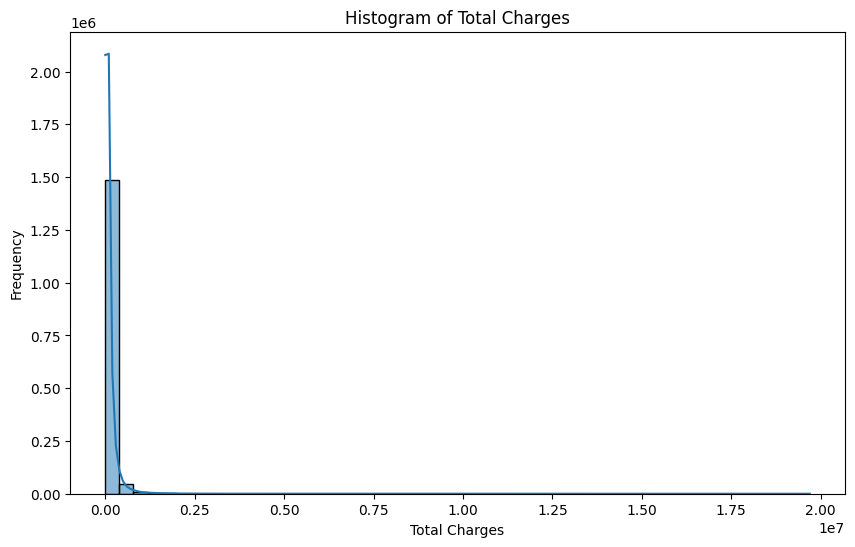

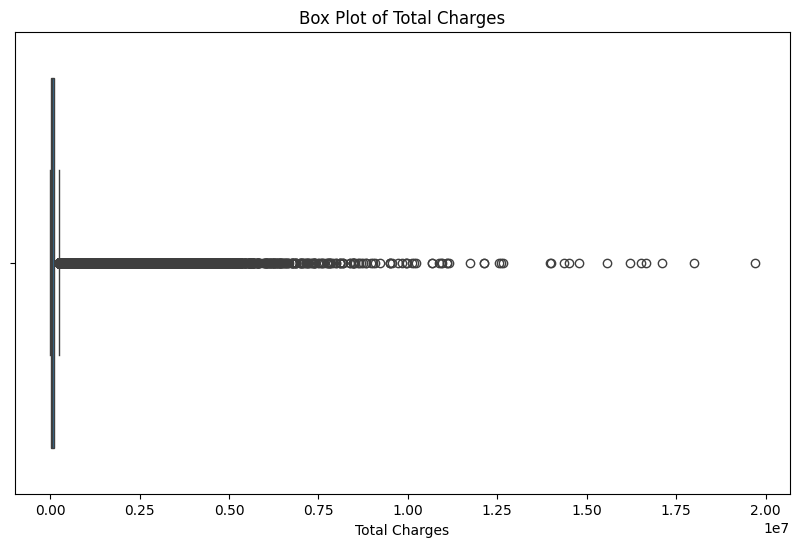

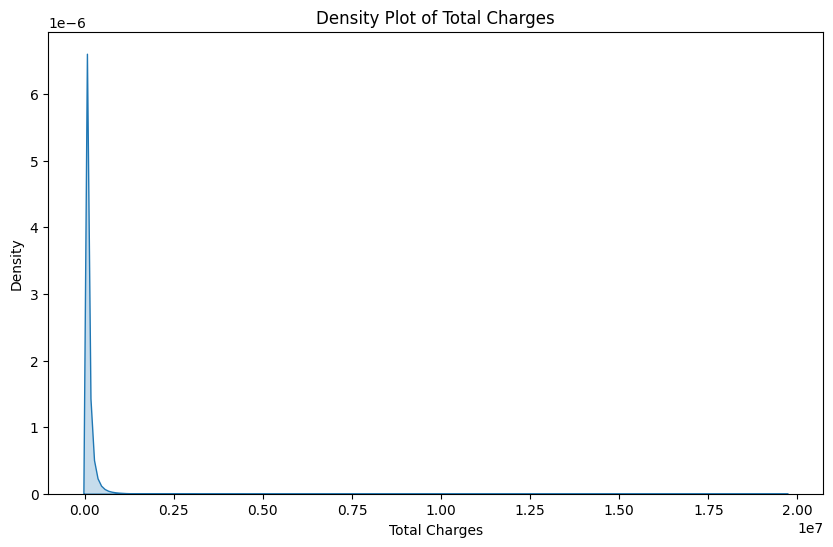

In [9]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Total Charges'], bins=50, kde=True)
plt.title('Histogram of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

# Plot box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Total Charges'])
plt.title('Box Plot of Total Charges')
plt.xlabel('Total Charges')
plt.show()

# Plot density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Total Charges'], fill=True)
plt.title('Density Plot of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Density')
plt.show()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548575 entries, 0 to 1548574
Data columns (total 28 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   Health Service Area                  1548575 non-null  object 
 1   Hospital County                      1548575 non-null  object 
 2   Operating Certificate Number         1548575 non-null  float64
 3   Permanent Facility Id                1548575 non-null  float64
 4   Facility Name                        1548575 non-null  object 
 5   Age Group                            1548575 non-null  object 
 6   Gender                               1548575 non-null  object 
 7   Race                                 1548575 non-null  object 
 8   Ethnicity                            1548575 non-null  object 
 9   Length of Stay                       1548575 non-null  object 
 10  Type of Admission                    1548575 non-null  object 
 11

In [11]:
df.drop(columns=['Discharge Year'],inplace=True)

In [12]:
df.shape

(1548575, 27)

In [13]:
obj_cols = df.columns.tolist()
preview_n = 10

for col in obj_cols:
    ser = df[col].astype(str)  # safe cast
    nunique = ser.nunique(dropna=False)
    print(f"{col} — dtype: object — unique: {nunique}")
    if nunique == 0:
        print("  <no values>")
    elif nunique <= 20:
        vals = sorted(ser.unique())
        print("  Distinct values:", vals)
    else:
        # show a few distinct examples and top value counts
        examples = ser.drop_duplicates().head(preview_n).tolist()
        print("  Examples (first {} distinct):".format(preview_n), examples)
        print("  Top 10 most common values:")
        print(ser.value_counts().head(10).to_string())
    print("-" * 80)

Health Service Area — dtype: object — unique: 8
  Distinct values: ['Capital/Adirondacks', 'Central NY', 'Finger Lakes', 'Hudson Valley', 'Long Island', 'New York City', 'Southern Tier', 'Western NY']
--------------------------------------------------------------------------------
Hospital County — dtype: object — unique: 56
  Examples (first 10 distinct): ['New York', 'Queens', 'Bronx', 'Westchester', 'Suffolk', 'Kings', 'Monroe', 'Nassau', 'Onondaga', 'Steuben']
  Top 10 most common values:
Hospital County
New York       333293
Kings          152005
Queens         138335
Nassau         134461
Bronx          128944
Suffolk        105547
Westchester     86896
Erie            74299
Monroe          60932
Onondaga        56854
--------------------------------------------------------------------------------
Operating Certificate Number — dtype: object — unique: 154
  Examples (first 10 distinct): ['7002054.0', '7002032.0', '7003004.0', '7000006.0', '7002009.0', '5153000.0', '7003001.0', '7

In [14]:
# ...existing code...
# Choose columns to convert (modify lists if you want different columns)
int_cols = [
    'Length of Stay',
]

float_cols = [
    'Total Costs',
    'Total Charges'
]

text_cols = [
    'Hospital County','Facility Name','Permanent Facility Id',
    'CCSR Diagnosis Code','CCSR Diagnosis Description','CCSR Procedure Code','APR DRG Code', 
    'APR DRG Description', 'Operating Certificate Number'
]


In [15]:
def clean_and_to_numeric(ser):
    s = ser.astype(str).fillna('').str.strip()
    # convert "(123)" -> "-123", remove $ and commas
    s = s.str.replace(r'^\((.*)\)$', r'-\1', regex=True)
    s = s.str.replace(r'[\$,]', '', regex=True)
    s = s.replace({'': np.nan, 'nan': np.nan, 'None': np.nan})
    return pd.to_numeric(s, errors='coerce')


# Convert integer-like columns robustly (overwrite originals)
for c in int_cols:
    if c in df.columns:
        num = clean_and_to_numeric(df[c])
        try:
            df[c] = num.astype('Int64')   # pandas nullable integer
        except Exception:
            # if all non-NaN values are whole numbers, cast to Int64; otherwise keep float
            if num.dropna().eq(num.dropna().astype(int)).all():
                df[c] = num.astype('Int64')
            else:
                df[c] = num.astype('Float64')
                print(f"Note: column '{c}' contains non-integer values; kept as Float64.")

# Convert float-like columns (overwrite originals)
for c in float_cols:
    if c in df.columns:
        df[c] = clean_and_to_numeric(df[c]).astype('Float64')

# Convert text columns (overwrite originals)
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype('string').str.strip().replace({'': pd.NA})

# Quick check
converted = [c for c in int_cols + float_cols + text_cols if c in df.columns]
print("Converted columns and dtypes:")
print(df[converted].dtypes)

Converted columns and dtypes:
Length of Stay                           Int64
Total Costs                            Float64
Total Charges                          Float64
Hospital County                 string[python]
Facility Name                   string[python]
Permanent Facility Id           string[python]
CCSR Diagnosis Code             string[python]
CCSR Diagnosis Description      string[python]
CCSR Procedure Code             string[python]
APR DRG Code                    string[python]
APR DRG Description             string[python]
Operating Certificate Number    string[python]
dtype: object


In [16]:
df.dtypes

Health Service Area                            object
Hospital County                        string[python]
Operating Certificate Number           string[python]
Permanent Facility Id                  string[python]
Facility Name                          string[python]
Age Group                                      object
Gender                                         object
Race                                           object
Ethnicity                                      object
Length of Stay                                  Int64
Type of Admission                              object
Patient Disposition                            object
CCSR Diagnosis Code                    string[python]
CCSR Diagnosis Description             string[python]
CCSR Procedure Code                    string[python]
APR DRG Code                           string[python]
APR DRG Description                    string[python]
APR MDC Code                                    int64
APR MDC Description         

In [17]:
for c in ['APR MDC Code', 'APR Severity of Illness Code']:
    if c in df.columns:
        # cast via pandas string to preserve missingness, then to generic object
        df[c] = df[c].astype('string').replace({'': pd.NA}).astype(object)

# quick check
print(df[['APR MDC Code', 'APR Severity of Illness Code']].dtypes)

APR MDC Code                    object
APR Severity of Illness Code    object
dtype: object


In [18]:
df.dtypes

Health Service Area                            object
Hospital County                        string[python]
Operating Certificate Number           string[python]
Permanent Facility Id                  string[python]
Facility Name                          string[python]
Age Group                                      object
Gender                                         object
Race                                           object
Ethnicity                                      object
Length of Stay                                  Int64
Type of Admission                              object
Patient Disposition                            object
CCSR Diagnosis Code                    string[python]
CCSR Diagnosis Description             string[python]
CCSR Procedure Code                    string[python]
APR DRG Code                           string[python]
APR DRG Description                    string[python]
APR MDC Code                                   object
APR MDC Description         

#### nunique <= 26 for label encoding

In [19]:
# 1) One-hot encode all object-dtype columns (overwrite originals)
one_hot_cols = df.select_dtypes(include=['object']).columns.tolist()
if one_hot_cols:
    dummies = pd.get_dummies(df[one_hot_cols].fillna('MISSING').astype(str), dtype=np.uint8)
    df.drop(columns=one_hot_cols, inplace=True)
    df = pd.concat([df, dummies], axis=1)
print("One-hot encoded columns expanded by:", len(dummies.columns) if one_hot_cols else 0)

One-hot encoded columns expanded by: 130


In [20]:
str_cols = df.select_dtypes(include=['string']).columns.tolist()
tf_parts = []
tfidf_params = dict(max_features=2000, ngram_range=(1,2), stop_words='english')
for c in str_cols:
    vec = TfidfVectorizer(**tfidf_params)
    Xc = vec.fit_transform(df[c].fillna('').astype(str))
    tf_parts.append(Xc)
    print(f"TF-IDF {c}: shape={Xc.shape}")

TF-IDF Hospital County: shape=(1548575, 60)
TF-IDF Operating Certificate Number: shape=(1548575, 154)
TF-IDF Permanent Facility Id: shape=(1548575, 197)
TF-IDF Facility Name: shape=(1548575, 693)
TF-IDF CCSR Diagnosis Code: shape=(1548575, 468)
TF-IDF CCSR Diagnosis Description: shape=(1548575, 1454)
TF-IDF CCSR Procedure Code: shape=(1548575, 318)
TF-IDF APR DRG Code: shape=(1548575, 326)
TF-IDF APR DRG Description: shape=(1548575, 1197)


In [21]:
target = 'Total Charges'
num_cols = df.select_dtypes(include=[np.number]).columns.drop([target], errors='ignore').tolist()
num_mat = sparse.csr_matrix(df[num_cols].fillna(0).astype(np.float32).values) if num_cols else sparse.csr_matrix((len(df), 0))
print("Numeric (including one-hot) shape:", num_mat.shape)


Numeric (including one-hot) shape: (1548575, 132)


In [22]:
parts = [num_mat] + tf_parts
X = sparse.hstack(parts, format='csr') if parts else sparse.csr_matrix((len(df), 0))
y = df[target].astype(np.float64).values

In [23]:
print("Final X shape:", X.shape)
print("y shape:", y.shape)

Final X shape: (1548575, 4999)
y shape: (1548575,)


In [25]:
model = Ridge(alpha=1)
r2 = cross_val_score(model, X, y, cv=10, scoring='r2', n_jobs=-1)
print("CV R^2 (per fold):", r2)
print("CV R^2 (mean):", r2.mean())

CV R^2 (per fold): [0.77594965 0.78342997 0.78704263 0.73496932 0.76829131 0.75923981
 0.74383138 0.75679583 0.7793108  0.74852605]
CV R^2 (mean): 0.7637386744318281


In [28]:
model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, num_leaves=31, random_state=42, n_jobs=-1)

# 10-fold CV, scoring by r2
scores = cross_val_score(model, X, y, cv=10, scoring='r2', n_jobs=-1)
print("LightGBM R^2 (per fold):", scores)
print("LightGBM R^2 (mean):", scores.mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.387238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13080
[LightGBM] [Info] Number of data points in the train set: 1393718, number of used features: 4844
[LightGBM] [Info] Start training from score 110418.206848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.901618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13095
[LightGBM] [Info] Number of data points in the train set: 1393718, number of used features: 4860
[LightGBM] [Info] Start training from score 110282.222041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.300396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.14/site-packag

LightGBM R^2 (per fold): [0.88621156 0.92890974 0.92140426 0.90565473 0.92917629 0.93197465
 0.88100221 0.93168537 0.91051898 0.93688198]
LightGBM R^2 (mean): 0.9163419772906469
